In [12]:
pip install numpy sklearn scipy pandas matplotlib TensorFlow opencv-python --upgrade


Requirement already up-to-date: numpy in /home/gabriel/anaconda3/lib/python3.7/site-packages (1.21.5)
Requirement already up-to-date: sklearn in /home/gabriel/anaconda3/lib/python3.7/site-packages (0.0)
Requirement already up-to-date: scipy in /home/gabriel/anaconda3/lib/python3.7/site-packages (1.7.3)
Requirement already up-to-date: pandas in /home/gabriel/anaconda3/lib/python3.7/site-packages (1.3.5)
Requirement already up-to-date: matplotlib in /home/gabriel/anaconda3/lib/python3.7/site-packages (3.5.1)
Requirement already up-to-date: TensorFlow in /home/gabriel/anaconda3/lib/python3.7/site-packages (2.8.0)
     |████████████████████████████████| 60.5 MB 42 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import pathlib

In [3]:
data_dir = 'Tomato-pest-image-enhancement'
img_height,img_width=180,180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='categorical',
  class_names = None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 4263 files belonging to 8 classes.
Using 852 files for validation.


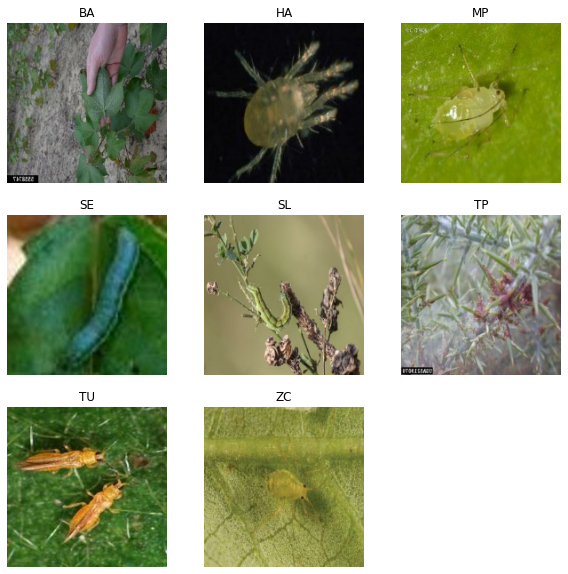

In [75]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [6]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
                    include_top=False,
                    input_shape=(180,180,3),
                    pooling='avg',classes=5,
                    weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [7]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(8, activation='softmax'))

In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=1)

107/107 [==============================] - 206s 2s/step - loss: 0.7196 - accuracy: 0.7649 - val_loss: 0.3326 - val_accuracy: 0.8991


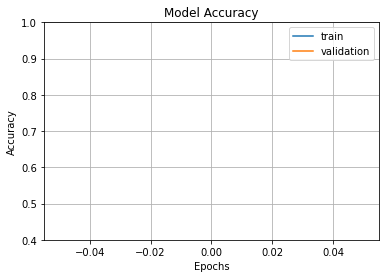

In [10]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [53]:
import cv2

data_dir = pathlib.Path(data_dir)

BA = list(data_dir.glob('BA/*'))


image=cv2.imread(str(BA[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)


In [54]:
pred=resnet_model.predict(image)

In [79]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is BA
